In [68]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, silhouette_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import time

In [69]:
data = pd.read_csv(r"/content/reduced_dataset3.csv")

In [70]:
X = data.drop('num',axis=1)
y = data['num']

In [71]:
# Split data for supervised learning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [72]:
# Scale data (important for SVM and K-Means)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)

# Function to evaluate models

In [73]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    return accuracy

# Function to perform hyperparameter tuning

In [74]:
def tune_model(model, param_grid, X_train, y_train, search_type='grid'):
    start_time = time.time()

    if search_type == 'grid':
        search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    else:
        search = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', n_iter=100 , n_jobs=-1)
    search.fit(X_train, y_train)

    print(f"Best parameters: {search.best_params_}")
    print(f"Best cross-validation score: {search.best_score_:.4f}")
    print(f"Time taken: {time.time() - start_time:.2f} seconds")

    return search.best_estimator_

# 1. Baseline Models (Supervised)

In [75]:
models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

baseline_results = {}
for name, model in models.items():
    print(f"\n{name} Baseline:")
    if name in ['SVM']:  # Models that need scaling
        acc = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    else:
        acc = evaluate_model(model, X_train, X_test, y_train, y_test)
    baseline_results[name] = acc



SVM Baseline:
Accuracy: 0.5889
              precision    recall  f1-score   support

           0       0.69      0.98      0.81        49
           1       0.17      0.12      0.14        17
           2       0.40      0.20      0.27        10
           3       0.33      0.09      0.14        11
           4       0.00      0.00      0.00         3

    accuracy                           0.59        90
   macro avg       0.32      0.28      0.27        90
weighted avg       0.49      0.59      0.51        90


Random Forest Baseline:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.5444
              precision    recall  f1-score   support

           0       0.75      0.90      0.81        49
           1       0.00      0.00      0.00        17
           2       0.30      0.30      0.30        10
           3       0.20      0.18      0.19        11
           4       0.00      0.00      0.00         3

    accuracy                           0.54        90
   macro avg       0.25      0.28      0.26        90
weighted avg       0.46      0.54      0.50        90


Decision Tree Baseline:
Accuracy: 0.4556
              precision    recall  f1-score   support

           0       0.75      0.73      0.74        49
           1       0.05      0.06      0.06        17
           2       0.38      0.30      0.33        10
           3       0.11      0.09      0.10        11
           4       0.00      0.00      0.00         3

    accuracy                           0.46        90
   macro avg       0.26      0.24      0.25        90
weighted avg      

# SVM

In [76]:
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly']
}
best_svm = tune_model(SVC(), svm_param_grid, X_train_scaled, y_train, 'grid')

print("\nSVM Randomized Search:")
best_svm_rand = tune_model(SVC(), svm_param_grid, X_train_scaled, y_train, 'random')


Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score: 0.5703
Time taken: 5.12 seconds

SVM Randomized Search:


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
Best cross-validation score: 0.5703
Time taken: 5.54 seconds


# Random Forest

In [79]:
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}
best_rf = tune_model(RandomForestClassifier(), rf_param_grid, X_train, y_train, 'grid')

print("\nRandom Forest Randomized Search:")
best_rf_rand = tune_model(RandomForestClassifier(), rf_param_grid, X_train, y_train, 'random')

Best parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 0.5801
Time taken: 2736.78 seconds

Random Forest Randomized Search:
Best parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 20}
Best cross-validation score: 0.5704
Time taken: 194.04 seconds


# Decision Tree

In [80]:
dt_param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
best_dt = tune_model(DecisionTreeClassifier(), dt_param_grid, X_train, y_train, 'grid')

print("\nDecision Tree Randomized Search:")
best_dt_rand = tune_model(DecisionTreeClassifier(), dt_param_grid, X_train, y_train, 'random')

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5}
Best cross-validation score: 0.5654
Time taken: 1.61 seconds

Decision Tree Randomized Search:


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 72 is smaller than n_iter=100. Running 72 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'entropy'}
Best cross-validation score: 0.5702
Time taken: 1.86 seconds


# Logistic Regression

In [81]:
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
best_lr = tune_model(LogisticRegression(max_iter=1000), lr_param_grid, X_train_scaled, y_train, 'grid')

print("\nLogistic Regression Randomized Search:")
best_lr_rand = tune_model(LogisticRegression(max_iter=1000), lr_param_grid, X_train_scaled, y_train, 'random')

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
240 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solv

Best parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.5799
Time taken: 4.20 seconds

Logistic Regression Randomized Search:
Best parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 100}
Best cross-validation score: 0.5799
Time taken: 3.04 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
240 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solv

# 3. Clustering Models (Unsupervised)

# K-Means Clustering

In [82]:
best_silhouette = -1
best_kmeans = None
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print(f"For n_clusters = {n_clusters}, silhouette score is {silhouette_avg:.4f}")

    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_kmeans = kmeans
        best_n_clusters = n_clusters

print(f"\nBest K-Means: n_clusters = {best_n_clusters}, silhouette score = {best_silhouette:.4f}")

For n_clusters = 2, silhouette score is 0.3159
For n_clusters = 3, silhouette score is 0.1581
For n_clusters = 4, silhouette score is 0.1816
For n_clusters = 5, silhouette score is 0.2260
For n_clusters = 6, silhouette score is 0.2252
For n_clusters = 7, silhouette score is 0.2262
For n_clusters = 8, silhouette score is 0.2445
For n_clusters = 9, silhouette score is 0.2403

Best K-Means: n_clusters = 2, silhouette score = 0.3159


# Hierarchical Clustering

In [83]:
best_silhouette_hc = -1
best_hc = None
for n_clusters in range(2, 10):
    hc = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = hc.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print(f"For n_clusters = {n_clusters}, silhouette score is {silhouette_avg:.4f}")

    if silhouette_avg > best_silhouette_hc:
        best_silhouette_hc = silhouette_avg
        best_hc = hc
        best_n_clusters_hc = n_clusters

print(f"\nBest Hierarchical Clustering: n_clusters = {best_n_clusters_hc}, silhouette score = {best_silhouette_hc:.4f}")

For n_clusters = 2, silhouette score is 0.3159
For n_clusters = 3, silhouette score is 0.1613
For n_clusters = 4, silhouette score is 0.2230
For n_clusters = 5, silhouette score is 0.2634
For n_clusters = 6, silhouette score is 0.2625
For n_clusters = 7, silhouette score is 0.2779
For n_clusters = 8, silhouette score is 0.2563
For n_clusters = 9, silhouette score is 0.2528

Best Hierarchical Clustering: n_clusters = 2, silhouette score = 0.3159


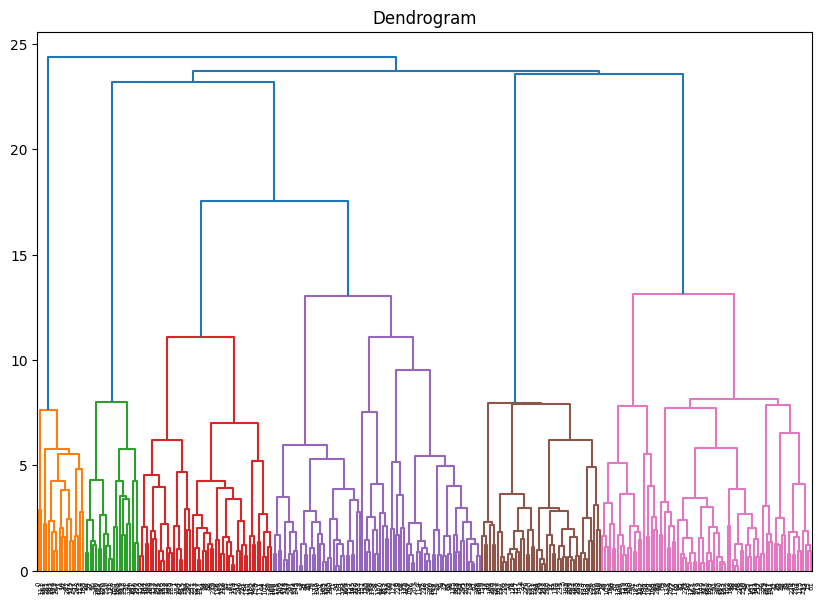

In [84]:
# Plot dendrogram for hierarchical clustering
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dend = dendrogram(linkage(X_scaled, method='ward'))
plt.show()

# 4. Final Evaluation

In [85]:
print("\n=== FINAL EVALUATION ===")
print("\nBaseline Performance:")
for name, acc in baseline_results.items():
    print(f"{name}: {acc:.4f}")

print("\nOptimized Models Performance:")
optimized_models = {
    "SVM (Grid)": best_svm,
    "SVM (Random)": best_svm_rand,
    "Random Forest (Grid)": best_rf,
    "Random Forest (Random)": best_rf_rand,
    "Decision Tree (Grid)": best_dt,
    "Decision Tree (Random)": best_dt_rand,
    "Logistic Regression (Grid)": best_lr,
    "Logistic Regression (Random)": best_lr_rand
}



=== FINAL EVALUATION ===

Baseline Performance:
SVM: 0.5889
Random Forest: 0.5444
Decision Tree: 0.4556
Logistic Regression: 0.6444

Optimized Models Performance:


In [86]:
optimized_results = {}
for name, model in optimized_models.items():
    print(f"\n{name}:")
    if 'SVM' in name or 'Logistic' in name:  # Models that need scaling
        acc = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    else:
        acc = evaluate_model(model, X_train, X_test, y_train, y_test)
    optimized_results[name] = acc


SVM (Grid):
Accuracy: 0.5889
              precision    recall  f1-score   support

           0       0.69      0.98      0.81        49
           1       0.17      0.12      0.14        17
           2       0.40      0.20      0.27        10
           3       0.33      0.09      0.14        11
           4       0.00      0.00      0.00         3

    accuracy                           0.59        90
   macro avg       0.32      0.28      0.27        90
weighted avg       0.49      0.59      0.51        90


SVM (Random):
Accuracy: 0.5889
              precision    recall  f1-score   support

           0       0.69      0.98      0.81        49
           1       0.17      0.12      0.14        17
           2       0.40      0.20      0.27        10
           3       0.33      0.09      0.14        11
           4       0.00      0.00      0.00         3

    accuracy                           0.59        90
   macro avg       0.32      0.28      0.27        90
weighted avg   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Accuracy: 0.5889
              precision    recall  f1-score   support

           0       0.71      0.96      0.82        49
           1       0.25      0.06      0.10        17
           2       0.27      0.30      0.29        10
           3       0.22      0.18      0.20        11
           4       0.00      0.00      0.00         3

    accuracy                           0.59        90
   macro avg       0.29      0.30      0.28        90
weighted avg       0.49      0.59      0.52        90


Decision Tree (Grid):
Accuracy: 0.5111
              precision    recall  f1-score   support

           0       0.70      0.80      0.74        49
           1       0.19      0.18      0.18        17
           2       0.43      0.30      0.35        10
           3       0.14      0.09      0.11        11
           4       0.00      0.00      0.00         3

    accuracy                           0.51        90
   macro avg       0.29      0.27      0.28        90
weighted avg       0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Compare with baseline

In [87]:
print("\nImprovement over baseline:")
for name, acc in optimized_results.items():
    base_name = name.split(' (')[0]
    if base_name in baseline_results:
        improvement = (acc - baseline_results[base_name]) / baseline_results[base_name] * 100
        print(f"{name}: {improvement:.2f}% improvement over baseline")


Improvement over baseline:
SVM (Grid): 0.00% improvement over baseline
SVM (Random): 0.00% improvement over baseline
Random Forest (Grid): 6.12% improvement over baseline
Random Forest (Random): 8.16% improvement over baseline
Decision Tree (Grid): 12.20% improvement over baseline
Decision Tree (Random): 24.39% improvement over baseline
Logistic Regression (Grid): -3.45% improvement over baseline
Logistic Regression (Random): -3.45% improvement over baseline
